# CPSC 368 Impact By State (KNM Neighbours)

## Loading Data and Packages

In [1]:
import oracledb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Impact by State import statements
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import LinearRegression

### Impact by State

In [2]:
# INPUT USER INFO HERE
CWL = ""
studentnum = ""

In [3]:
# Acquire data
dsn = oracledb.makedsn("localhost", 1522, service_name="stu")
connection = oracledb.connect(user=f"ora_{CWL}", password=f"a{studentnum}", dsn=dsn)
cur = connection.cursor()

try:
    # SQL code
    cur.execute(
        """
        SELECT 
            us."LocationDesc" AS LOCATIONDESC,
            us."DataValueUnit" AS DeathRateUnit,
            us."DataValueType" AS DeathRateType,
            us."DataValue" AS AvgDeathRate,
            us."Stratification1" AS STRATIFICATION1,
            kff.All_Uninsured
        FROM USCDI_filter us
        LEFT JOIN KFF2019_new kff
            ON us."LocationDesc" = kff.Location
        WHERE us."Topic" = 'Cardiovascular Disease'
            AND us."Question" = 'Coronary heart disease mortality among all people, underlying cause'
            AND us."DataValueUnit" = 'cases per 100,000'
            AND us."StratificationCategory1" = 'Age'
            AND us."Stratification1" IN ('Age 0-44', 'Age 45-64', 'Age >=65')
            AND us."DataValueType" = 'Crude Rate'
            AND us."LocationDesc" != 'United States'
        """
    )
    
    # Fetch SELECT results 
    rows = cur.fetchall()
    
    # Get column names from cursor
    columns = [desc[0] for desc in cur.description]
    
    # Create DataFrame
    state_df = pd.DataFrame(rows, columns=columns).fillna(0)
    
    print("Completed dataframe.")
except Exception as e:
    print(f"Error executing SQL query: {e}")
finally: 
    cur.close()
    connection.close()

Completed dataframe.


In [4]:
state_df.head()

,LOCATIONDESC,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,STRATIFICATION1,ALL_UNINSURED
0,Alabama,"cases per 100,000",Crude Rate,4.4,Age 0-44,0.149
1,Alabama,"cases per 100,000",Crude Rate,86.0,Age 45-64,0.149
2,Alabama,"cases per 100,000",Crude Rate,434.6,Age >=65,0.149
3,Alaska,"cases per 100,000",Crude Rate,0.0,Age 0-44,0.153
4,Alaska,"cases per 100,000",Crude Rate,72.3,Age 45-64,0.153


In [5]:
USCDI = pd.read_csv('final_datasets_V1/cleaned/USCDI.csv')
KFF2019_new = pd.read_csv("final_datasets_V1/cleaned/KFF2019_new.csv")

In [6]:
# condition_2_t = USCDI["Topic"] == "Cardiovascular Disease"
# condition_2_q = USCDI["Question"] == "Coronary heart disease mortality among all people, underlying cause"
# condition_2_dvu = USCDI["DataValueUnit"] == "cases per 100,000"
# condition_2_sc1 = USCDI["StratificationCategory1"] == "Age"
# condition_2_s1 = USCDI['STRATIFICATION1'].isin(['Age 0-44', 'Age 45-64'])
# condition_2_dvt = USCDI["DataValueType"] == "Crude Rate"
# condition_2_2019 = USCDI["Has2019"] == 1

# USCDI_state = USCDI[condition_2_t & condition_2_q & condition_2_dvu & condition_2_sc1 & condition_2_dvt & condition_2_2019]
# USCDI_state = USCDI_state[USCDI_state['LOCATIONDESC'] != 'United States'] # Drop Rows where LocationDesc is equal to United States

# state_df = pd.merge(USCDI_state, KFF2019_new[['Location', 'ALL_UNINSURED']], 
#                      left_on='LOCATIONDESC', right_on='Location', how='left')
# state_df.drop(columns='Location', inplace=True)
# state_df.rename(columns={'AvgDataValue': 'AVGDEATHRATE'}, inplace=True) #Rename DataValue Column to AvgDeathRate for better interpretability
# state_df.rename(columns={'DataValueType': 'DeathRateType'}, inplace=True) #Rename DataValueType Column to DeathRateType for better interpretability
# state_df.rename(columns={'DataValueUnit': 'DeathRateUnit'}, inplace=True) #Rename DataValueUnit Column to DeathRateUnit for better interpretability
# state_df = state_df[['LOCATIONDESC', "DeathRateUnit", "DeathRateType", "AvgDeathRate", "Stratification1", 'ALL_UNINSURED']]

state_df.to_csv("final_datasets_V1/cleaned/state_df.csv", index=False)

In [7]:
state_df_0_44 = state_df[state_df['STRATIFICATION1'] == 'Age 0-44']
state_df_45_64 = state_df[state_df['STRATIFICATION1'] == 'Age 45-64']
state_df_65 = state_df[state_df['STRATIFICATION1'] == 'Age >=65']

display(state_df.head())

,LOCATIONDESC,DEATHRATEUNIT,DEATHRATETYPE,AVGDEATHRATE,STRATIFICATION1,ALL_UNINSURED
0,Alabama,"cases per 100,000",Crude Rate,4.4,Age 0-44,0.149
1,Alabama,"cases per 100,000",Crude Rate,86.0,Age 45-64,0.149
2,Alabama,"cases per 100,000",Crude Rate,434.6,Age >=65,0.149
3,Alaska,"cases per 100,000",Crude Rate,0.0,Age 0-44,0.153
4,Alaska,"cases per 100,000",Crude Rate,72.3,Age 45-64,0.153


In [8]:
state_df['STRATIFICATION1'].unique()

array(['Age 0-44', 'Age 45-64', 'Age >=65'], dtype=object)

In [9]:
print(state_df.isnull().sum())

LOCATIONDESC       0
DEATHRATEUNIT      0
DEATHRATETYPE      0
AVGDEATHRATE       0
STRATIFICATION1    0
ALL_UNINSURED      0
dtype: int64


Since the `state_df` contains overlapping rows with the same values for certain columns, I’ve decided to further split the data based on age stratification. This will ensure that each state has a unique uninsured rate and death rate for each age group, helping to eliminate redundancy and providing more precise and meaningful insights for the analysis.

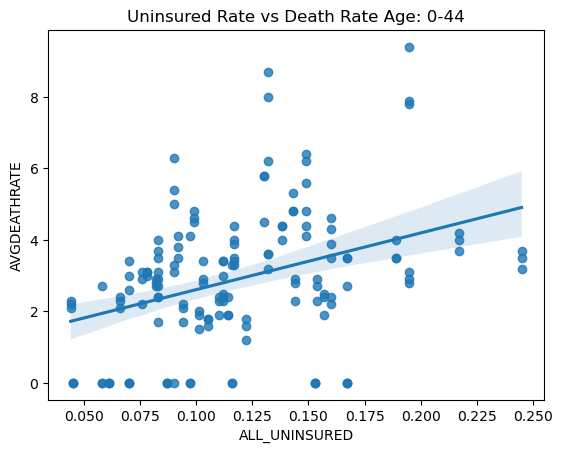

In [10]:
sns.regplot(data=state_df_0_44, x='ALL_UNINSURED', y='AVGDEATHRATE', scatter=True)
plt.title('Uninsured Rate vs Death Rate Age: 0-44')
plt.show()

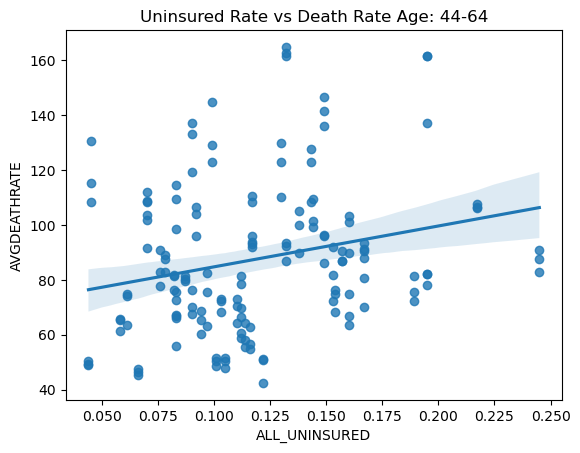

In [11]:
sns.regplot(data=state_df_45_64, x='ALL_UNINSURED', y='AVGDEATHRATE', scatter=True)
plt.title('Uninsured Rate vs Death Rate Age: 44-64')
plt.show()

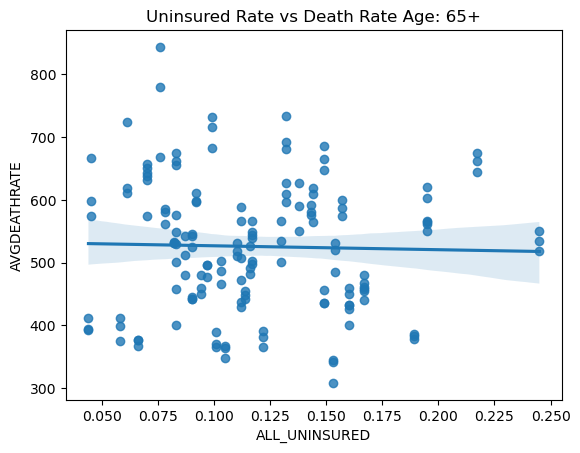

In [12]:
sns.regplot(data=state_df_65, x='ALL_UNINSURED', y='AVGDEATHRATE', scatter=True)
plt.title('Uninsured Rate vs Death Rate Age: 65+')
plt.show()

/var/folders/sp/136d3tf94ns_hpp_7z4mgphm0000gp/T/ipykernel_45923/1087953225.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=state_df_65, x='LOCATIONDESC', y='ALL_UNINSURED', jitter=True, palette="Set2", alpha=0.7)


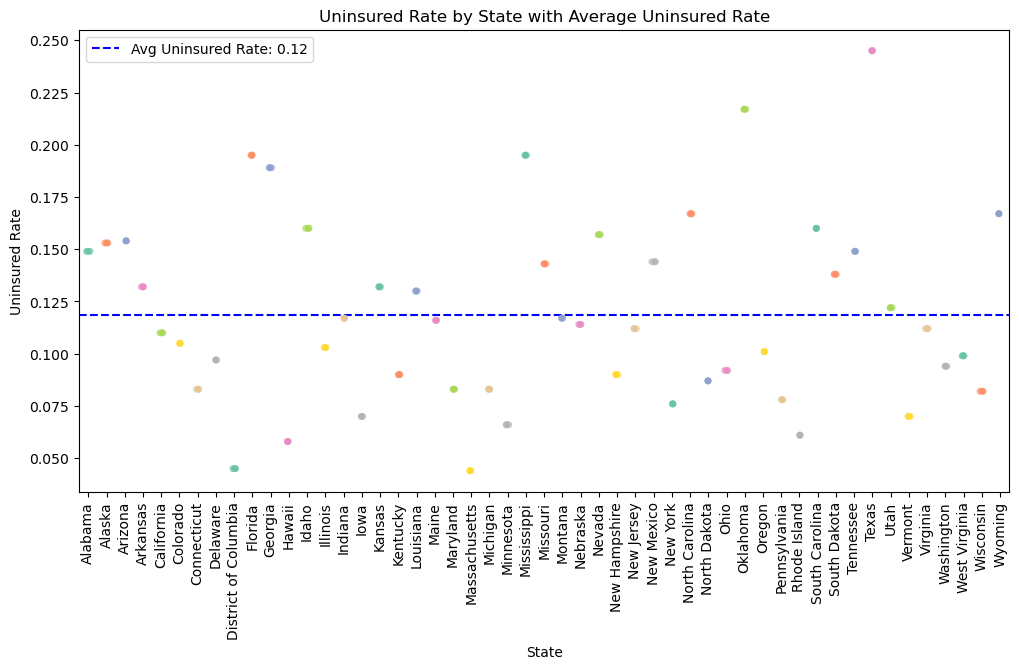

In [13]:
average_uninsured_rate = state_df_65['ALL_UNINSURED'].mean()

plt.figure(figsize=(12, 6))
sns.stripplot(data=state_df_65, x='LOCATIONDESC', y='ALL_UNINSURED', jitter=True, palette="Set2", alpha=0.7)
plt.axhline(y=average_uninsured_rate, color='blue', linestyle='--', label=f'Avg Uninsured Rate: {average_uninsured_rate:.2f}')
plt.title("Uninsured Rate by State with Average Uninsured Rate")
plt.xlabel("State")
plt.ylabel("Uninsured Rate")
plt.xticks(rotation=90)
plt.legend()
plt.show()

These regression plots show the scatter plot of individual data points along with the best-fit line from the regression. Since the scatter plot lacks a clear trend and the best-fit line has a shallow slope, it suggests that the features have limited predictive power for Death Rate. However, we'll explore how a more complex model, like SVR, performs.

#### Splitting the Data
To begin, we separate the features from the target variable. Then we'll split the dataset into training and test sets using an 80/20 split. Next, we divide the dataset into training and test sets. Additionally, we apply a log transformation to the target variable to reduce skewness and reduce the impact of outliers, with `np.log1p()` specifically to handle cases where `state_df_0_44['ALL_UNINSURED'] == 0`. This transformation not only improves the model's fit but also enhances interpretability by stabilizing variance and making the relationships between variables more linear.

In [14]:
State_X_0_44 = state_df_0_44[['ALL_UNINSURED', 'LOCATIONDESC']]
State_y_0_44 = np.log1p(state_df_0_44['AVGDEATHRATE'])

X_train_0_44, X_test_0_44, y_train_0_44, y_test_0_44 = train_test_split(State_X_0_44, State_y_0_44, test_size=0.2, random_state=42)

#### Preprocessing and Pipeline
We'll use a column transformer to scale the numerical features and apply One-Hot Encoding to the location column, ensuring that the influence of each state is captured. We will then assemble these steps into a pipeline, making the process repeatable for other datasets. 

In [15]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', make_pipeline(
            MinMaxScaler()
        ), ['ALL_UNINSURED']),
        ('cat', make_pipeline(
            OneHotEncoder(handle_unknown='ignore')
        ), ['LOCATIONDESC'])
    ]
)

pipe = make_pipeline(
    preprocessor,
    SVR()
)

ttr = TransformedTargetRegressor(
    regressor=pipe,
    transformer=StandardScaler()
)

#### Hyperparameter Optimization
We will now perform hyperparameter optimization to identify the best set of parameters for achieving optimal model performance.

In [16]:
param_grid = {
    'regressor__svr__C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'regressor__svr__epsilon': [0.01, 0.1, 0.2, 0.5, 0.08, 1.6, 2.4, 3.2],
    'regressor__svr__gamma': ['scale', 'auto', 0.01, 0.1, 1, 10, 100],
    'regressor__svr__kernel': ['linear', 'rbf', 'poly']
}

grid_search_0_44 = GridSearchCV(ttr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_0_44.fit(X_train_0_44, y_train_0_44)

print(grid_search_0_44.best_estimator_)

TransformedTargetRegressor(regressor=Pipeline(steps=[('columntransformer',
                                                      ColumnTransformer(transformers=[('num',
                                                                                       Pipeline(steps=[('minmaxscaler',
                                                                                                        MinMaxScaler())]),
                                                                                       ['ALL_UNINSURED']),
                                                                                      ('cat',
                                                                                       Pipeline(steps=[('onehotencoder',
                                                                                                        OneHotEncoder(handle_unknown='ignore'))]),
                                                                                       ['LOCATIONDESC'])])),
          

#### Remodel with Best Hyperparameters
Having identified the best hyperparameters, we will now retrain the SVR model using these values to achieve optimal performance. We will assess the model using RMSE to assess it's accuracy

In [17]:
y_pred_0_44 = grid_search_0_44.best_estimator_.predict(X_test_0_44)

rmse_0_44 = np.sqrt(mean_squared_error(y_test_0_44, y_pred_0_44))

print(f"Best Parameters: {grid_search_0_44.best_params_}")
print(f"Test RMSE: {rmse_0_44:.2f}")

Best Parameters: {'regressor__svr__C': 100, 'regressor__svr__epsilon': 0.1, 'regressor__svr__gamma': 100, 'regressor__svr__kernel': 'poly'}
Test RMSE: 0.50


#### AvgDeathRate by States Age: 44-64
Now we'll repeat the steps with the other age stratifications

In [18]:
State_X_45_64 = state_df_45_64[['ALL_UNINSURED', 'LOCATIONDESC']]
State_y_45_64 = np.log1p(state_df_45_64['AVGDEATHRATE'])

X_train_45_64, X_test_45_64, y_train_45_64, y_test_45_64 = train_test_split(State_X_45_64, State_y_45_64, test_size=0.2, random_state=42)

grid_search_45_64 = GridSearchCV(ttr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_45_64.fit(X_train_45_64, y_train_45_64)

y_pred_45_64 = grid_search_45_64.best_estimator_.predict(X_test_45_64)

rmse_45_64 = np.sqrt(mean_squared_error(y_test_45_64, y_pred_45_64))

print(f"Best Parameters: {grid_search_45_64.best_params_}")
print(f"Test RMSE: {rmse_45_64:.2f}")

Best Parameters: {'regressor__svr__C': 10, 'regressor__svr__epsilon': 0.01, 'regressor__svr__gamma': 10, 'regressor__svr__kernel': 'rbf'}
Test RMSE: 0.09


#### AvgDeathRate by States Age: 65+

In [19]:
State_X_65 = state_df_65[['ALL_UNINSURED', 'LOCATIONDESC']]
State_y_65 = np.log1p(state_df_65['AVGDEATHRATE'])

X_train_65, X_test_65, y_train_65, y_test_65 = train_test_split(State_X_65, State_y_65, test_size=0.2, random_state=42)

grid_search_65 = GridSearchCV(ttr, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_65.fit(X_train_65, y_train_65)

y_pred_65 = grid_search_65.best_estimator_.predict(X_test_65)

rmse_65 = np.sqrt(mean_squared_error(y_test_65, y_pred_65))

print(f"Best Parameters: {grid_search_65.best_params_}")
print(f"Test RMSE: {rmse_65:.2f}")

Best Parameters: {'regressor__svr__C': 10, 'regressor__svr__epsilon': 0.08, 'regressor__svr__gamma': 0.1, 'regressor__svr__kernel': 'rbf'}
Test RMSE: 0.05


#### Results

In [20]:
results_df = pd.DataFrame({
    'Age Group': ['0-44', '45-64', '65+'],
    'Test RMSE': [rmse_0_44, rmse_45_64, rmse_65]
})
print(results_df)

  Age Group  Test RMSE
0      0-44   0.501478
1     45-64   0.094254
2       65+   0.053935


Our models have a low RMSE in the log transformed space meaning that the predictions are close to the actual values in the dataset. Let's look at some of the support vectors that our model uses

#### Age 0-44 Support Vectors

In [21]:
best_ttr_model_0_44 = grid_search_0_44.best_estimator_
best_pipeline_0_44 = best_ttr_model_0_44.regressor_
best_svr_model_0_44 = best_pipeline_0_44.named_steps['svr']

support_vectors_0_44 = best_svr_model_0_44.support_vectors_
encoder_0_44 = best_pipeline_0_44.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder']
encoded_columns_0_44 = encoder_0_44.get_feature_names_out(input_features=['LOCATIONDESC'])
support_vector_indices_0_44 = best_svr_model_0_44.support_
original_data_support_vectors_0_44 = X_train_0_44.iloc[support_vector_indices_0_44]
encoded_location_desc_values_0_44 = encoder_0_44.transform(original_data_support_vectors_0_44[['LOCATIONDESC']]).toarray()

for idx, encoded_vector in zip(support_vector_indices_0_44, encoded_location_desc_values_0_44):
    location_desc_value_0_44 = encoded_columns_0_44[encoded_vector.astype(bool)].tolist()
    print(f"Support vector {idx} (age 0-44): LocationDesc value(s) = {location_desc_value_0_44}")


Support vector 3 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_Vermont']
Support vector 4 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_Missouri']
Support vector 6 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_New York']
Support vector 7 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_New Jersey']
Support vector 8 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_Montana']
Support vector 9 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_Nebraska']
Support vector 10 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_Illinois']
Support vector 11 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_South Carolina']
Support vector 13 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_California']
Support vector 14 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_New York']
Support vector 15 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_Connecticut']
Support vector 17 (age 0-44): LocationDesc value(s) = ['LOCATIONDESC_Arizona']
Support vector 19 (age 0-44): Locati

#### Age 45-64 Support Vectors

In [22]:
best_ttr_model_45_64 = grid_search_45_64.best_estimator_
best_pipeline_45_64 = best_ttr_model_45_64.regressor_
best_svr_model_45_64 = best_pipeline_45_64.named_steps['svr']

support_vectors_45_64 = best_svr_model_45_64.support_vectors_
encoder_45_64 = best_pipeline_45_64.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder']
encoded_columns_45_64 = encoder_45_64.get_feature_names_out(input_features=['LOCATIONDESC'])
support_vector_indices_45_64 = best_svr_model_45_64.support_
original_data_support_vectors_45_64 = X_train_45_64.iloc[support_vector_indices_45_64]
encoded_location_desc_values_45_64 = encoder_45_64.transform(original_data_support_vectors_45_64[['LOCATIONDESC']]).toarray()

for idx, encoded_vector in zip(support_vector_indices_45_64, encoded_location_desc_values_45_64):
    location_desc_value_45_64 = encoded_columns_45_64[encoded_vector.astype(bool)].tolist()
    print(f"Support vector {idx} (age 45-64): LOCATIONDESC value(s) = {location_desc_value_45_64}")


Support vector 0 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Texas']
Support vector 1 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Kentucky']
Support vector 2 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Michigan']
Support vector 3 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Vermont']
Support vector 4 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Missouri']
Support vector 5 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Hawaii']
Support vector 6 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_New York']
Support vector 7 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_New Jersey']
Support vector 8 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Montana']
Support vector 9 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Nebraska']
Support vector 10 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_Illinois']
Support vector 11 (age 45-64): LOCATIONDESC value(s) = ['LOCATIONDESC_South Carolina']
Support vector 12 (age 45-64): LOCATI

#### Age 65+ Support Vectors

In [23]:
best_ttr_model_65 = grid_search_65.best_estimator_
best_pipeline_65 = best_ttr_model_65.regressor_
best_svr_model_65 = best_pipeline_65.named_steps['svr']
support_vectors_65 = best_svr_model_65.support_vectors_
encoder_65 = best_pipeline_65.named_steps['columntransformer'].transformers_[1][1].named_steps['onehotencoder']
encoded_columns_65 = encoder_65.get_feature_names_out(input_features=['LOCATIONDESC'])

support_vector_indices_65 = best_svr_model_65.support_
original_data_support_vectors_65 = X_train_65.iloc[support_vector_indices_65]
encoded_location_desc_values_65 = encoder_65.transform(original_data_support_vectors_65[['LOCATIONDESC']]).toarray()

for idx, encoded_vector in zip(support_vector_indices_65, encoded_location_desc_values_65):
    location_desc_value_65 = encoded_columns_65[encoded_vector.astype(bool)].tolist()
    print(f"Support vector {idx} (age 65+): LOCATIONDESC value(s) = {location_desc_value_65}")


Support vector 0 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Texas']
Support vector 3 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Vermont']
Support vector 4 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Missouri']
Support vector 5 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Hawaii']
Support vector 6 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_New York']
Support vector 8 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Montana']
Support vector 10 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Illinois']
Support vector 11 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_South Carolina']
Support vector 14 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_New York']
Support vector 15 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Connecticut']
Support vector 17 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Arizona']
Support vector 18 (age 65+): LOCATIONDESC value(s) = ['LOCATIONDESC_Kansas']
Support vector 19 (age 65+): LOCATIONDESC value(s) = ['LOCA

Since there are many support vectors for `LOCATIONDESC` in the age groups 0-44 and 45-64, this suggests that `LOCATIONDESC` does not provide strong or consistent differentiation for these age groups. In other words, `LOCATIONDESC` might not be a strong predictor for these age groups in the context of predicting coronary heart disease (CHD) mortality.

However, the fact that there are fewer support vectors for the 65+ age group indicates that `LOCATIONDESC` might have some degree of predictive power for this group. This could suggest that geographic location plays a larger role in predicting CHD mortality for older adults.

Additionally, it is notable that Rhode Island appears as a support vector for all three age groups, which could indicate that this state has unique characteristics or patterns influencing CHD mortality across different age groups. This may suggest that certain regional factors in Rhode Island are particularly relevant to the model, regardless of the age group being analyzed.

Overall, the lack of a clear and consistent pattern across all age groups implies that there is no definitive, universal relationship between uninsured rates and CHD mortality across all U.S. states. The influence of `LOCATIONDESC` on CHD mortality appears to vary by age group, with certain states, like Rhode Island, potentially playing a more significant role.